# Data Science template - Titanic Case

Deze notebook begeleidt je stap voor stap door de **Titanic**-case op Kaggle.
De focus ligt op de standaard Data Science workflow:

1. Probleemdefinitie en doel
2. Data-input & Data cleaning
3. Verkenning (EDA)
4. Feature engineering
5. Modelleren (baseline → verbeterde modellen)
6. **Voorspelling** en export van `submission.csv`

> 🎯 Doel: voorspel de kans dat een passagier de Titanic-vaart heeft overleefd (`Survived`).

Probleemdefinitie:

- **Input**: passagiersgegevens zoals `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, etc.
- **Output**: binaire target `Survived` (0 = niet overleefd, 1 = overleefd).
- **Metric (Kaggle leaderboard)**: **Accuracy** op de testset (zonder labels).

## 1. Imports

In [228]:
import pandas as pd
import numpy as np

# Visualisatie
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & evaluatie
# import sklearn

# Hiermee laat je alle kolommen standaard zien
pd.set_option('display.max_columns', None)

# 2. Data inladen

In [229]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape, test.shape)

(891, 12) (418, 11)


# 3. Datacheck

- Numeriek: imputatie (median) + scaling
- Categorisch: imputatie (most_frequent) + one-hot encoding

In [230]:
display(train.sample(5, random_state=42))
display(train.describe(include='all'))
train.isna().mean().sort_values(ascending=False)[:10]

print(train.isna().sum())

train = train.dropna(subset = ["Age"])
test = test.dropna(subset = ["Age"])

# Age veranderd van float naar int
train['Age'] = train['Age'].astype(int)

# Splitsing van kolommen met numerieke waarden en catergorische waarden om plots te kunnen onderscheiden
train_num = train[['Age', 'SibSp', 'Parch', 'Fare']]
train_cat = train[['Sex', 'Pclass', 'Ticket', 'Cabin', 'Embarked']]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## 4. Data opschonen

Let op: 
- Waar missen we (rijen met) data?
- Waar hebben we overbodige (dubbele) data?
- Waar hebben we foute data die in de kolommen staan?

In [231]:
# Met dit vullen we alle NaN's in kolom Age met het gemiddelde per geslacht
train['Age'] = train['Age'].fillna(train.groupby('Sex')['Age'].transform('mean'))
test['Age'] = train['Age'].fillna(train.groupby('Sex')['Age'].transform('mean'))

In [232]:
# Kolom aangemaakt om te zien hoeveel pp betaald
train['Ticket_Count'] = train.groupby('Ticket')['Ticket'].transform('count')
train['Fare_per_person'] = train['Fare'] / train['Ticket_Count']
train['Fare'] = train['Fare_per_person']

# Kolom aangemaakt om te zien welke leeftijds groepen horen bij de PaassengerId
train['Age_Group'] = np.select(
    [train['Age'] < 1, (train['Age'] >= 1) & (train['Age'] < 15), train['Age'] >= 15],
    ['Infant', 'Child', 'Adult'],
    default='Unknown')

In [233]:
# Tarieven verschillen per leeftijdsgroep
train['FareWeight'] = np.select(
    [train['Age_Group'] == 'Infant', train['Age_Group'] == 'Child', train['Age_Group'] == 'Adult'],
    [0.0, 0.5, 1.0]
)

# Berekening van het totale gewicht per ticket (gehele ticket)
train['TotalFareWeight'] = train.groupby('Ticket')['FareWeight'].transform('sum')

# Berekening van de waarde per gewichtseenheid (tarief per volwassene)
train['Fare_per_weight'] = train['Fare'] / train['TotalFareWeight']

# Berekening van de aangepaste fare (0.0 en 0.5 zodat ticket eerlijk verdeeld wordt)
train['AdjustedFare'] = train['Fare_per_weight'] * train['FareWeight']

# Oude kolom verwijderen (verkeerde data)
train.drop(columns=['Fare_per_person'], inplace=True, errors='ignore')

# Nieuwe kolom hernoemen naar juiste naam
train.rename(columns={'AdjustedFare': 'Fare_per_person'}, inplace=True)

train.drop(columns=['FareWeight', 'TotalFareWeight', 'Fare_per_weight'], inplace=True, errors='ignore')


In [234]:
# Filter: alleen kinderen in 3e klas
children_third_class = train[(train['Pclass'] == 3) & (train['Age_Group'] == 'Child')]

# Berekeningen
total_fare = children_third_class['Fare_per_person'].sum()
average_fare = children_third_class['Fare_per_person'].mean()
count_children = len(children_third_class)

# Resultaat tonen
print(f"Aantal kinderen in 3e klas: {count_children}")
print(f"Totaal betaalde bedrag door kinderen in 3e klas: £{total_fare:.2f}")
print(f"Gemiddelde prijs per kind: £{average_fare:.2f}")

children_third_class = train[(train['Age_Group'] == 'Child') & (train['Pclass'] == 3)]
children_third_class.head().round(2)

Aantal kinderen in 3e klas: 51
Totaal betaalde bedrag door kinderen in 3e klas: £155.39
Gemiddelde prijs per kind: £3.05


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Count,Age_Group,Fare_per_person
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,5.27,NaN,S,4,Child,1.05
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,8.35,G6,S,2,Child,2.78
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14,0,0,350406,7.85,NaN,S,1,Child,7.85
16,17,0,3,"Rice, Master. Eugene",male,2,4,1,382652,5.82,NaN,Q,5,Child,0.97
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8,3,1,349909,5.27,NaN,S,4,Child,1.05


## 5. Verkennende Data Analyse (EDA)

> Tip: Voeg hier extra grafieken toe (bijv. histogrammen, boxplots, countplots per feature).


In [235]:
# Voorbeeld: verdeling overleven per geslacht
pd.crosstab(train['Sex'], train['Survived'], normalize='index')


# Word misschien gebruikt
'''
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1

def fam_bucket(fs):
    if fs == 1: 
        return "Alleen"
    elif 2 <= fs <= 4:
        return "Klein (2-4)"
    else:
        return "Groot (5+)"

train["FamilyGroup"] = train["FamilySize"].apply(fam_bucket)

# Survival rate per FamilyGroup
group_stats = (
    train.groupby("FamilyGroup")["Survived"]
         .agg(SurvivalRate="mean", PassengerCount="size")
         .reindex(["Alleen", "Klein (2-4)", "Groot (5+)"])  # logische volgorde
         .reset_index()
)

print(group_stats)  # tabel met resultaten

# Plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=group_stats, x="FamilyGroup", y="SurvivalRate")
ax.set_title("Overlevingskans: Alleen vs. met familie")
ax.set_xlabel("Familiegroep")
ax.set_ylabel("Gem. overlevingskans")

# aantallen boven de balken
for p, n in zip(ax.patches, group_stats["PassengerCount"]):
    ax.annotate(f"Aantal Passagiers={n}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", xytext=(0, 3), textcoords="offset points")

plt.show()
'''

'\ntrain["FamilySize"] = train["SibSp"] + train["Parch"] + 1\n\ndef fam_bucket(fs):\n    if fs == 1: \n        return "Alleen"\n    elif 2 <= fs <= 4:\n        return "Klein (2-4)"\n    else:\n        return "Groot (5+)"\n\ntrain["FamilyGroup"] = train["FamilySize"].apply(fam_bucket)\n\n# Survival rate per FamilyGroup\ngroup_stats = (\n    train.groupby("FamilyGroup")["Survived"]\n         .agg(SurvivalRate="mean", PassengerCount="size")\n         .reindex(["Alleen", "Klein (2-4)", "Groot (5+)"])  # logische volgorde\n         .reset_index()\n)\n\nprint(group_stats)  # tabel met resultaten\n\n# Plot\nplt.figure(figsize=(7,5))\nax = sns.barplot(data=group_stats, x="FamilyGroup", y="SurvivalRate")\nax.set_title("Overlevingskans: Alleen vs. met familie")\nax.set_xlabel("Familiegroep")\nax.set_ylabel("Gem. overlevingskans")\n\n# aantallen boven de balken\nfor p, n in zip(ax.patches, group_stats["PassengerCount"]):\n    ax.annotate(f"Aantal Passagiers={n}", (p.get_x()+p.get_width()/2, p.get

In [236]:
# Voorbeeld: verdeling leeftijd (met eenvoudige imputatie voor visualisatie)
# we verwijderen simpelweg alle rijen waar geen leeftijd bekend is.
train["status"] = np.where(train["Survived"] == 1, "Overleeft", "Overleden")

plt.figure()
'''
sns.set_palette(["lime", "r"])
f = sns.catplot(kind = "count",x = "Pclass", hue = "status", data = train )
f.fig.suptitle("Hoeveelheid passagiers per klasse met overlevingsstatus")
f.set(xlabel = "Klasse", ylabel = "Aantal")
plt.show()

sns.set_palette(["r","black"])
k = sns.histplot(data=train,x="Age", hue="status",alpha = 0.6, multiple="dodge")
k.set_title("Verdeling van de leeftijden")
k.set_xlabel("Leeftijd")
k.set_ylabel("Aantal")
plt.show()

sns.set_palette(["r", "lime"])
n = sns.boxplot(data=train,x="status", y= "Age", hue = "status")
n.set_title("Leeftijd vs overlevingsstatus")
n.set_xlabel("Overlevingsstatus")
n.set_ylabel("Leeftijd")
plt.show()

sns.set_style("whitegrid")
sns.set_palette(["b","y"])
p = sns.relplot(data=train,x="Age",y="Fare",kind='scatter',hue="status",alpha=0.5)
p.fig.suptitle("Leeftijd vs Kosten")
p.set(xlabel = "Leeftijd", ylabel = "Kosten")

sns.set_palette(["r","purple"])
g = sns.catplot(data=train,x="Sex", y="Survived", kind="bar", hue ="Sex")
g.fig.suptitle("overlevingskans per geslacht")
g.set(xlabel = "Gender", ylabel = "Overlevingskans")

b = sns.catplot(data = train, x = "Pclass", hue = "Sex", kind = "count")
b.fig.suptitle("Aantal passagiers per klasse per gender")
b.set(xlabel = "Klasse", ylabel = "Aantal")
plt.show()


d = sns.boxplot( data = train, x = "Sex", y = "Age", hue = "Sex")
d.set_title("Gender vs Leeftijd")
d.set_xlabel("Gender")
d.set_ylabel("Leeftijd")
plt.show()

'''

'\nsns.set_palette(["lime", "r"])\nf = sns.catplot(kind = "count",x = "Pclass", hue = "status", data = train )\nf.fig.suptitle("Hoeveelheid passagiers per klasse met overlevingsstatus")\nf.set(xlabel = "Klasse", ylabel = "Aantal")\nplt.show()\n\nsns.set_palette(["r","black"])\nk = sns.histplot(data=train,x="Age", hue="status",alpha = 0.6, multiple="dodge")\nk.set_title("Verdeling van de leeftijden")\nk.set_xlabel("Leeftijd")\nk.set_ylabel("Aantal")\nplt.show()\n\nsns.set_palette(["r", "lime"])\nn = sns.boxplot(data=train,x="status", y= "Age", hue = "status")\nn.set_title("Leeftijd vs overlevingsstatus")\nn.set_xlabel("Overlevingsstatus")\nn.set_ylabel("Leeftijd")\nplt.show()\n\nsns.set_style("whitegrid")\nsns.set_palette(["b","y"])\np = sns.relplot(data=train,x="Age",y="Fare",kind=\'scatter\',hue="status",alpha=0.5)\np.fig.suptitle("Leeftijd vs Kosten")\np.set(xlabel = "Leeftijd", ylabel = "Kosten")\n\nsns.set_palette(["r","purple"])\ng = sns.catplot(data=train,x="Sex", y="Survived", k

<Figure size 640x480 with 0 Axes>

In [237]:
# Oefening: voeg je eigen EDA toe
# Gebruik Seaborn in plaats van Matplotlib.
# TODO: tel bijvoorbeeld overlevingspercentage per Pclass, Embarked, Fare-quantiles (pd.qcut), etc.

In [238]:
train_num = train[['Age', 'SibSp', 'Parch', 'Fare']]
train_cat = train[['Sex', 'Pclass', 'Ticket', 'Cabin', 'Embarked']]

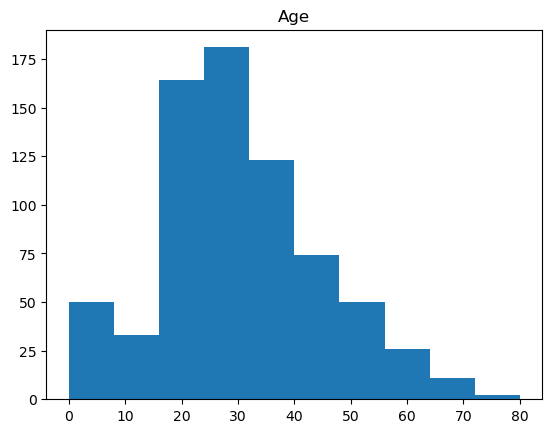

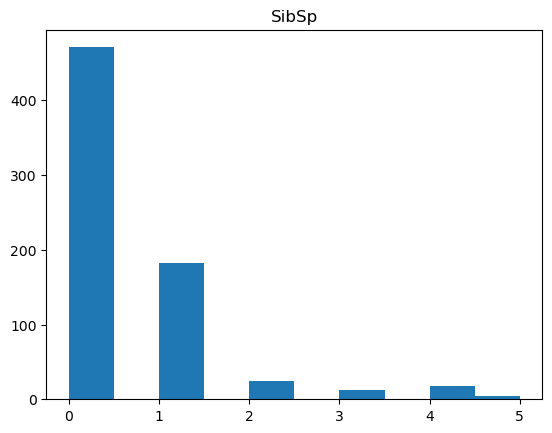

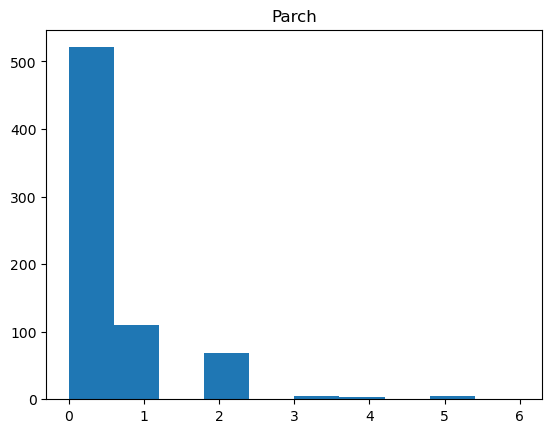

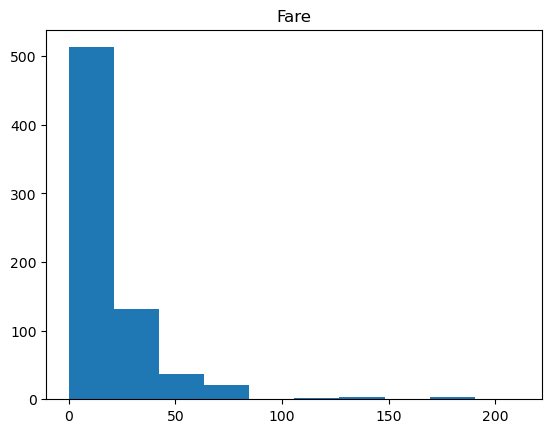

In [239]:
for col in train_num.columns:
    plt.hist(train_num[col])
    plt.title(col)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.307947 -0.189307  0.234918
SibSp -0.307947  1.000000  0.383820 -0.000319
Parch -0.189307  0.383820  1.000000  0.054992
Fare   0.234918 -0.000319  0.054992  1.000000


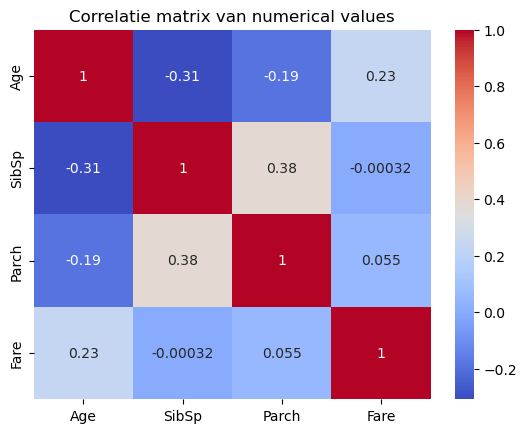

In [240]:
print(train_num.corr())
sns.heatmap(train_num.corr(), annot=True, cmap='coolwarm')
plt.title("Correlatie matrix van numerical values")
plt.show()


In [241]:
# ik wil zien: Survived kans aan de hand van deze waardes
''' de mensen die Survived(1) of niet Survived(0) zijn zo gemiddeld zo oud etc.'''

pd.pivot_table(train, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.606132,14.130882,0.365566,0.525943
1,28.324138,27.071838,0.527586,0.493103


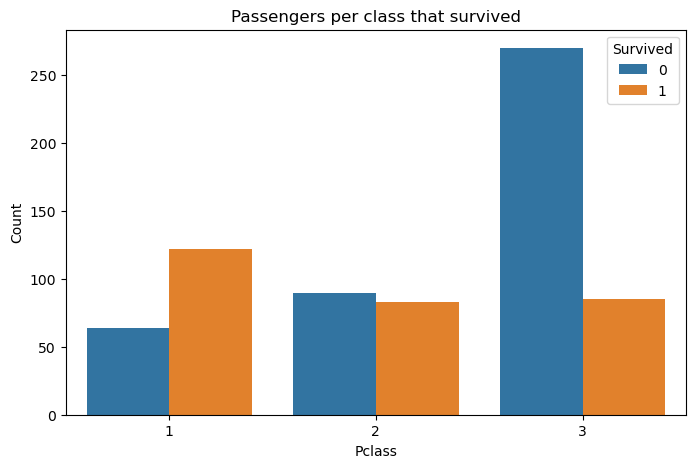

In [242]:
plt.figure(figsize=(8,5))
axtrain1 = sns.countplot(data=train, x='Pclass', hue='Survived')
axtrain1.set_title('Passengers per class that survived')
axtrain1.set_xlabel('Pclass')
axtrain1.set_ylabel('Count')
plt.legend(title='Survived')
plt.show()

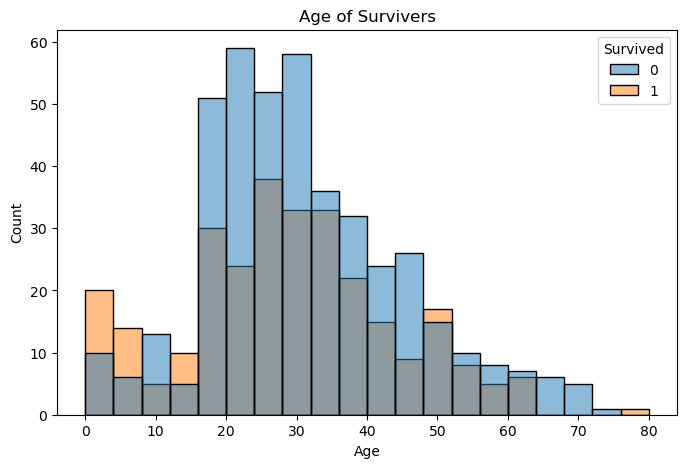

In [243]:
plt.figure(figsize=(8,5))
axtrain2 = sns.histplot(data=train, x='Age', hue='Survived')
axtrain2 = plt.title('Age of Survivers')
axtrain2 = plt.xlabel('Age')
axtrain2 = plt.ylabel('Count')
plt.show()

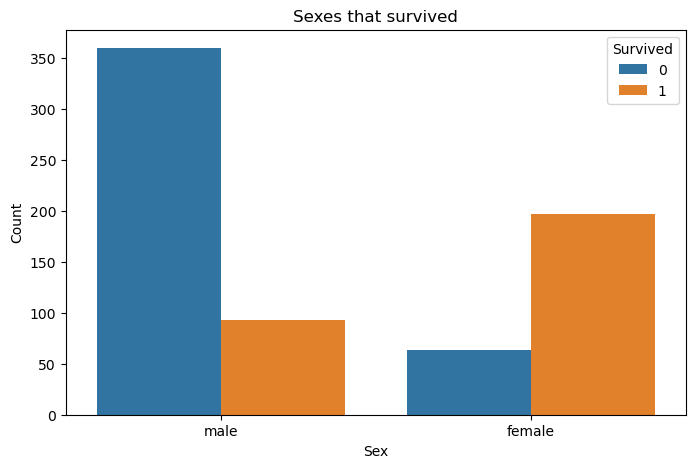

In [244]:
plt.figure(figsize=(8,5))
axtrain3 = sns.countplot(data=train, x='Sex', hue='Survived')
axtrain3 = plt.title('Sexes that survived')
axtrain3 = plt.xlabel('Sex')
axtrain3 = plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()

## 6. Feature Engineering

Voeg hier zelf extra features toe (bijv. `Title` uit `Name`, `FamilySize = SibSp + Parch + 1`, indicatoren, etc.).

Zorg wel dat het relevant is voor je eigen onderzoek. Waar ligt je eigen focus.

In [245]:
# Je kan nu zelf features aanmaken invullen. 



## 7. Baseline model — np.where invullen

In [246]:
# === 3. Regelgebaseerde baseline met np.where ===
# Regel: vrouwen overleven altijd, jongens (<10 jaar) ook, anders niet
train_pred = np.where(
    train['Age'] <= 10,1, np.where(train["Age"] >= 65, 0, np.where(train["Pclass"] == 3, 0, np.where(train["Sex"] == "female", 1,0))))



## 8. Maak een eindmodel op volledige trainingsdata en voorspel op test

Hier kiezen we als voorbeeld het np.where model (of gebruik anders een ander model).


In [247]:
# === 4. Toepassen op testset ===
test_pred = np.where(
    test['Age'] <= 10,1, np.where(test["Age"] >= 65, 0, np.where(test["Pclass"] == 3, 0, np.where(test["Sex"] == "female", 1,0)))
      
)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("submission.csv aangemaakt!")
submission.head() 

submission.csv aangemaakt!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## 9. Checklist & Volgende stappen

- [ ] Zorg dat er een duidelijke samenhang is tussen de grafieken -> Feature Engineering -> je uiteindelijke model! Dat is het belangrijkst.
- [ ] Laat geen grafieken zien waar je niks mee doet tijdens de presentatie.
- [ ] Zorg dat er dus een rode draad is in je verhaal. 

Voorbeeld: We hebben de focus gelegd op leeftijd -> EDA laat deze grafieken met leeftijd zien. We hebben met Feature Engineering nog leeftijdsgroepen aangemaakt -> We hebben in het model de leeftijden gebruikt. Dit is onze score.

- [ ] Eventueel EDA (een klein beetje) uitbreiden (meer grafieken, correlaties, outliers)
- [ ] Feature engineering verbeteren (wat is er relevant?)
- [ ] Meer modellen proberen (Logistic Regression? Sklearn)
- [ ] Submission inleveren op kaggle en kijken hoe goed je score is

Succes met de case!